# Get the libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, r2_score, silhouette_score, davies_bouldin_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from yellowbrick.cluster import KElbowVisualizer

from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
wine=pd.read_csv('/Users/Jeff/Downloads/winequality.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [4]:
wine.shape

(6497, 14)

# Data preprocessing

## Missing value

In [5]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
good                    0
color                   0
dtype: int64

No missing value

## Columns data types

In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  good                  6497 non-null   int64  
 13  color                 6497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


As we can most of the columns are numerical, there is only column color which is object type

### Color column

In [7]:
# Check the value counts of the column
wine.color.value_counts()

white    4898
red      1599
Name: color, dtype: int64

As we only have 2 values in the color column, we will use label encoder to assign a numerical value to each categorical value

In [8]:
dct={'white':0, 'red':1}
wine.color=wine.color.map(dct)

In [9]:
wine.color.value_counts()

0    4898
1    1599
Name: color, dtype: int64

In [10]:
# Check the dtype
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  good                  6497 non-null   int64  
 13  color                 6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


Ok all columns are numerical

## Other column manipulation

### good column

In [11]:
# See the value counts of column "good"
wine.good.value_counts()

0    5220
1    1277
Name: good, dtype: int64

In [12]:
# See the value counts of column "quality" when the column "good" is equal to 1
wine.loc[wine['good']==1].quality.value_counts()

7    1079
8     193
9       5
Name: quality, dtype: int64

In [13]:
# See the value counts of column "quality" when the column "good" is equal to 0
wine.loc[wine['good']==0].quality.value_counts()

6    2836
5    2138
4     216
3      30
Name: quality, dtype: int64

In [14]:
# See the value counts of column "quality"
wine.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

As we can see, the column good is determined by the column quality. We don't need to keep both column, we choose to drop the column good as it has less information and our goal is to predict the quality

In [15]:
# Drop the column "good"
wine.drop('good', axis=1, inplace=True)

### Color column

We don't think that the color has an impact on the quality of the wine. So we decide to drop this column.

In [16]:
# Drop color column
wine.drop('color', axis=1, inplace=True)

### Quality column (output)

As we can see our output is categorical ordinal values. In order to build a regression model we will assign to a category each value:
* if quality < 6 then bad (0)
* if quality < 8 then medium (1)
* if quality > 8 then good (2)

In [17]:
wine.quality=np.where(wine.quality < 6, 0, wine.quality)
wine.quality=np.where(wine.quality == 6, 1, wine.quality)
wine.quality=np.where(wine.quality == 7, 1, wine.quality)
wine.quality=np.where(wine.quality > 7, 2, wine.quality)

In [18]:
wine.quality.value_counts()

1    3915
0    2384
2     198
Name: quality, dtype: int64

## Scale

In [19]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


As we can see, the columns have not the same scale, we will rescale our database. \
We will use StandardScaler()

In [20]:
scaler=StandardScaler()
X_scale=scaler.fit_transform(wine.drop('quality', axis=1))

In [21]:
X=pd.DataFrame(X_scale)

In [22]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [23]:
X.columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [24]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464


# Imbalance

In [25]:
# Define y
y=wine['quality']

In [26]:
counter=Counter(y)
print(counter)

Counter({1: 3915, 0: 2384, 2: 198})


As we can see, our y is highly imbalanced. We will use oversampling and undersampling in order to rebalanced out output

In [27]:
over_strategy={2:1000}
under_strategy={1: 3000}

over=RandomOverSampler(sampling_strategy=over_strategy)
under=RandomUnderSampler(sampling_strategy=under_strategy)

steps=[('o',over), ('u',under)]
pipe=Pipeline(steps=steps)

X_im,y_im=pipe.fit_resample(X,y)

counter=Counter(y_im)
print(counter)

Counter({1: 3000, 0: 2384, 2: 1000})


# Features selection

As we have only numerical columns, we will use SelectKbest with f_classif

In [28]:
X_im.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068
3,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
4,0.142473,1.945855,-2.192833,-0.765798,0.541412,-0.987451,-1.340197,1.034993,1.813090,0.193097,-0.915464


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_im, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

In [30]:
fs = SelectKBest(score_func=f_classif, k=6)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [31]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 40.814650
Feature 1: 225.781608
Feature 2: 23.093582
Feature 3: 1.284035
Feature 4: 159.161799
Feature 5: 31.847370
Feature 6: 6.630084
Feature 7: 379.117808
Feature 8: 3.373569
Feature 9: 4.351380
Feature 10: 829.984852


In [32]:
X.columns[fs.get_support()]

Index(['fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide',
       'density', 'alcohol'],
      dtype='object')

We have identified the useful and useless features for our model

**Useful features:**
* fixed acidity
* volatile acidity
* citric acid
* chlorides
* density
* alcohol

**Useless features:**
* residual sugar
* free sulfur dioxide
* total sulfur dioxide
* pH
* sulphates

# Clustering

In [33]:
X_useless=X_im[['residual sugar','free sulfur dioxide','total sulfur dioxide','pH','sulphates']]

## Determine the optimal number of clusters

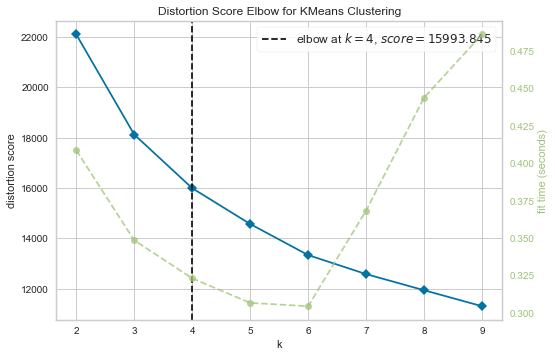

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_useless)
visualizer.show()

/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


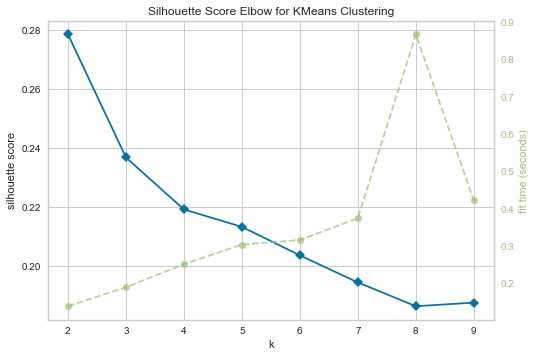

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_useless)
visualizer.show()

/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/Cellar/jupyterlab/2.2.0/libexec/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


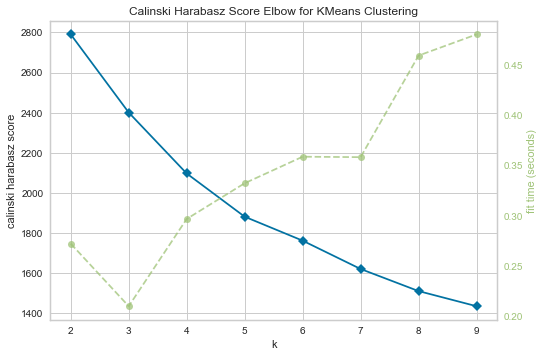

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [36]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz')

visualizer.fit(X_useless)
visualizer.show()

According to KElbowVisulize, the best number of cluster is 4.

## Create the cluster

In [37]:
km=KMeans(4)
km.fit(X_useless)
km.predict(X_useless)

array([0, 0, 0, ..., 2, 3, 3], dtype=int32)

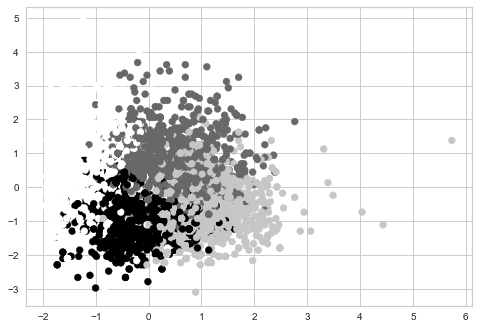

In [38]:
plt.scatter(X_useless.iloc[:,2],X_useless.iloc[:,3], c=km.predict(X_useless))

As we can the clusterisation are very dense

In [39]:
tree=DecisionTreeClassifier()
tree.fit(X_useless, km.predict(X_useless))

DecisionTreeClassifier()

In [40]:
confusion_matrix(km.predict(X_useless), tree.predict(X_useless))

array([[1515,    0,    0,    0],
       [   0, 1568,    0,    0],
       [   0,    0, 1625,    0],
       [   0,    0,    0, 1676]])

[0.26006103 0.13417398 0.27749312 0.21691914 0.11135274]


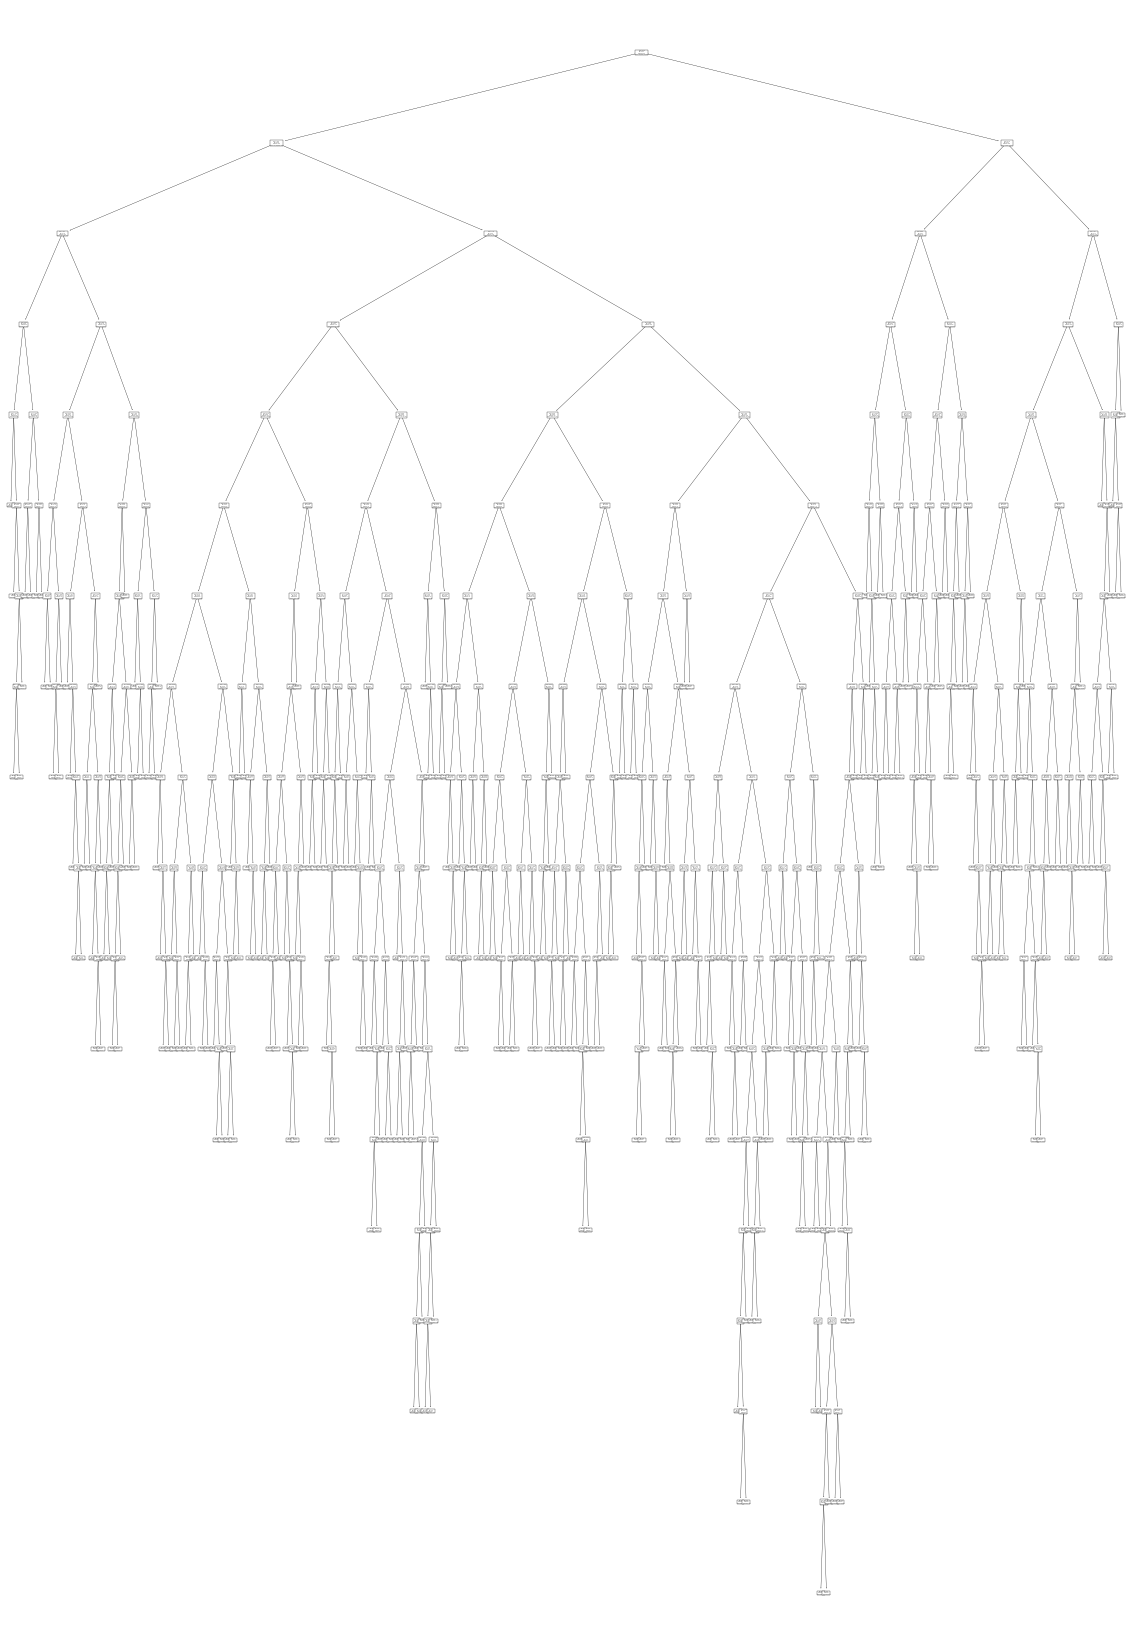

In [41]:
print(tree.feature_importances_)
plt.figure(figsize=(20,30))
plot_tree(tree)
plt.show()

As we can see, there are lots of branches. It confirm that my clusterisation is very dense.

In [42]:
print('Bouldin score is', davies_bouldin_score(X_useless, km.predict(X_useless)))
print('Silhouette score is', silhouette_score(X_useless, km.predict(X_useless)))

Bouldin score is 1.4232534007834037
Silhouette score is 0.21909090137118684


In [43]:
# Create labels
labels=km.labels_
labels

array([0, 0, 0, ..., 2, 3, 3], dtype=int32)

In [44]:
# Identify the count of each cluster
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1515, 1568, 1625, 1676]))

Now we need to add the labels column into X as dummies

In [45]:
# Add the label column
X_im['label']=labels

In [46]:
# Get dummies for label column
X_cluster=pd.get_dummies(data=X_im, columns=['label'])

In [47]:
# Drop useless columns
X_cluster.drop(['free sulfur dioxide','total sulfur dioxide','pH','sulphates'], axis=1, inplace=True)

In [48]:
X_cluster.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,density,alcohol,label_0,label_1,label_2,label_3
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,1.034993,-0.915464,1,0,0,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,0.701486,-0.580068,1,0,0,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,0.768188,-0.580068,1,0,0,0
3,0.142473,2.188833,-2.192833,-0.744778,0.569958,1.034993,-0.915464,1,0,0,0
4,0.142473,1.945855,-2.192833,-0.765798,0.541412,1.034993,-0.915464,1,0,0,0


# Modelling

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_cluster, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

In [50]:
X_cluster.to_csv('Wine_X_cluster.csv', sep='/', index=False)

## Decision Tree (with clustering)

In [51]:
model_tree=DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
y_pred_tree=model_tree.predict(X_test)
conf_tree=confusion_matrix(y_test, y_pred_tree)
acc_tree=accuracy_score(y_test, y_pred_tree)
rec_tree=recall_score(y_test, y_pred_tree, average='macro')
pre_tree=precision_score(y_test, y_pred_tree, average='macro')
f1_tree=f1_score(y_test, y_pred_tree, average='macro')
display(conf_tree)
print('Accuracy', acc_tree)
print('Recall', rec_tree)
print('Precision', pre_tree)
print('F1', f1_tree)

array([[336, 137,   4],
       [136, 442,  22],
       [  0,   1, 199]])

Accuracy 0.7650743931088488
Recall 0.8120230607966458
Precision 0.7861259389137824
F1 0.7979123115374636


## Random Forest Classifier (with clustering)

In [56]:
model_rf=RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf=model_rf.predict(X_test)
y_pred_xt___=model_rf.predict_proba(X_test)

conf_rf=confusion_matrix(y_test, y_pred_rf)
acc_rf=accuracy_score(y_test, y_pred_rf)
rec_rf=recall_score(y_test, y_pred_rf, average='macro')
pre_rf=precision_score(y_test, y_pred_rf, average='macro')
f1_rf=f1_score(y_test, y_pred_rf, average='macro')
roc_auc_score_xt=roc_auc_score(y_test, y_pred_xt___, multi_class='ovo')

display(conf_rf)
print('Accuracy', acc_rf)
print('Recall', rec_rf)
print('Precision', pre_rf)
print('F1', f1_rf)
print('AUC', roc_auc_score_xt)

NameError: name 'roc_auc_score' is not defined

## Random Forest Classifier (without clustering)

In [53]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_im, \
                                                  y_im, \
                                                  train_size=0.8, \
                                                  random_state=42, \
                                                  stratify=y_im)

In [55]:
model_rf1=RandomForestClassifier()
model_rf1.fit(X_train1, y_train1)
y_pred_rf1=model_rf1.predict(X_test1)
conf_rf1=confusion_matrix(y_test1, y_pred_rf1)
acc_rf1=accuracy_score(y_test1, y_pred_rf1)
rec_rf1=recall_score(y_test1, y_pred_rf1, average='macro')
pre_rf1=precision_score(y_test1, y_pred_rf1, average='macro')
f1_rf1=f1_score(y_test1, y_pred_rf1, average='macro')
display(conf_rf1)
print('Accuracy', acc_rf1)
print('Recall', rec_rf1)
print('Precision', pre_rf1)
print('F1', f1_rf1)

array([[378,  99,   0],
       [100, 497,   3],
       [  0,   1, 199]])

Accuracy 0.841033672670321
Recall 0.8719287211740042
Precision 0.869479768775431
F1 0.8706940482060475
